In [213]:
## STANDARD IMPORTS
import os
import time
import h5py
import numpy as np
import numpy.ma as ma
import pandas as pd
import json

!pip install ../../../h5flow
import h5flow
from h5flow.data import dereference

## 3D PLOTTING
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib import cm, colors
import matplotlib.patches as mpatches
from matplotlib.colors import BoundaryNorm

Processing /Users/james/DUNE/h5flow
  Preparing metadata (setup.py) ... done
  Created wheel for h5flow: filename=h5flow-0.2.4-py3-none-any.whl size=31486 sha256=8f70f2780b6a7fc8783f4cdf6d657932d64e198beca3a81e45a676c6c04aa180
  Stored in directory: /private/var/folders/rc/blk_p25x629bs2hm6s03qd7r0000gp/T/pip-ephem-wheel-cache-9ncwijhr/wheels/24/88/52/69f8c19ba5cdb192c9c8611f03e4d3b4e2b4c27d2131bc4e20
Successfully built h5flow
  Attempting uninstall: h5flow
    Found existing installation: h5flow 0.2.4
    Uninstalling h5flow-0.2.4:
      Successfully uninstalled h5flow-0.2.4


In [214]:
#dirname = 'data_processed_mpd_run_hvramp_rctl_105_p350.FLOW_TrapType_evts_all'
dirname = 'mc_processed_MiniRun5_1E19_RHC.flow.0000000.FLOW_TrapType_evts_all'
spes_filename = dirname+'/spes_evt.npz'
noise_filename = dirname+'/noise_evt.npz'
config_filename = dirname+'/config.json'
hits_filename = dirname+'/hits_evt.npz'
hits_config_filename = dirname+'/hits_config.json'

# print configuration and hit configuration
with open(config_filename) as json_file:
    config = json.load(json_file)
    print(json.dumps(config, indent=4))
with open(hits_config_filename) as json_file:
    hits_config = json.load(json_file)
    print(json.dumps(hits_config, indent=4))



{
    "timestamp": "2024-12-18 15:05:36.883884",
    "filename": "../hdf5s/MiniRun5_1E19_RHC.flow.0000000.FLOW.hdf5",
    "is_data": false,
    "summed": "TrapType",
    "max_evts": null,
    "calib_filename": "calibration/mc_calib.csv",
    "geom_filename": "geom_files/light_module_desc-4.0.0.csv",
    "channel_status_filename": "channel_status/channel_status.csv",
    "maskfile": "channel_sum_masks/TrapType_masks_mc.npz"
}
{
    "n_noise_factor": 10.0,
    "n_bins_rolled": 5,
    "n_sqrt_rt_factor": 3.0,
    "pe_weight": 1.0
}


In [215]:
def plot_waveform(wvfm, time_bins, height, mad, n_mad_factor, dynamic_threshold, hit_where, n_noise_factor, i_evt_lrs, i_mask):

  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
  # set a title
  fig.suptitle(f'Event {i_evt_lrs}, TPC {i_mask // 2}, TrapType {i_mask % 2}')

  # Linear plot
  ax1.plot(time_bins, wvfm)
  ax1.axhspan(-mad, mad, color='k', alpha=0.1, label='MAD')
  ax1.axhline(mad*n_mad_factor, color='k', linestyle='--', alpha=0.5, label='MAD threshold')
  ax1.axhspan(-height, height, color='r', alpha=0.1, label='Masked samples Stddev')
  ax1.axhline(n_noise_factor*height, color='r', linestyle='--', alpha=0.5, label='Noise threshold')
  ax1.plot(time_bins, dynamic_threshold, color='g', alpha=0.5)
  ax1.plot(hit_where * 16/1000, wvfm[hit_where], 'x', color='red')
  ax1.axhline(0, color='k', linestyle=':', alpha=0.5)
  ax1.set_xlabel('Time (us)')
  ax1.set_ylabel('SPEs')
  ax1.legend()

  # Logarithmic plot
  ax2.plot(time_bins, wvfm + 1)
  ax2.axhspan(0, mad + 1, color='k', alpha=0.1)
  ax2.axhline(mad*n_mad_factor + 1, color='k', linestyle='--', alpha=0.5)
  ax2.axhspan(0, height + 1, color='r', alpha=0.1)
  ax2.axhline(n_noise_factor*height+1, color='r', linestyle='--', alpha=0.5)
  ax2.plot(time_bins, dynamic_threshold + 1, color='g', alpha=0.5)
  ax2.plot(hit_where * 16/1000, wvfm[hit_where] + 1, 'x', color='red')
  ax2.axhline(1, color='k', linestyle=':', alpha=0.5)
  ax2.set_yscale('log')
  ax2.set_xlabel('Time (us)')
  ax2.set_ylim(0.1, dynamic_threshold.max()*1.1)

  plt.tight_layout()
  plt.show()

[481 649]


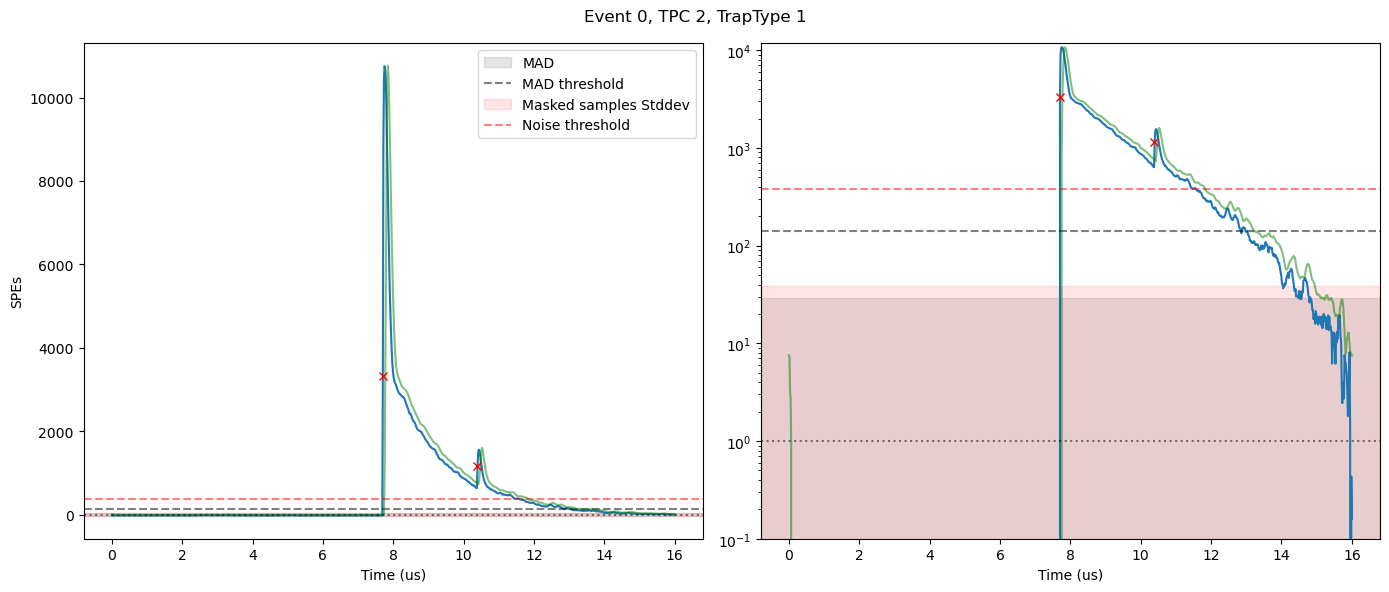

In [216]:
from scipy.ndimage import uniform_filter1d

# load hit finder config
with open(hits_config_filename) as json_file:
    hits_config = json.load(json_file)
n_noise_factor = hits_config['n_noise_factor']
n_bins_rolled = hits_config['n_bins_rolled']
n_sqrt_rt_factor = hits_config['n_sqrt_rt_factor']
pe_weight = hits_config['pe_weight']


# loading events
time_bins = np.linspace(0, 16, 1000)

# wvfms
summed_wvfms_file = np.load(spes_filename)
summed_wvfms = np.array(summed_wvfms_file['arr_0'])

# noise thresholds
heights_file = np.load(noise_filename)
heights = np.array(heights_file['arr_0'])

# loading hits
hits_file = np.load(hits_filename)
hits = np.array(hits_file['arr_0'])

# find first event with hits != -1
i_mask = 5 # 2 * TPC + TrapType
i_evt_lrs = 0 #3705 # event number

# get wvfm, threshold, and hits for the event
wvfm = summed_wvfms[i_evt_lrs,i_mask]
median = np.median(wvfm)
mad = np.median(np.abs(wvfm - median))
mad_threshold = 5*mad
wvfm_rolled = np.roll(wvfm, n_bins_rolled)
rolling_average = uniform_filter1d(wvfm_rolled, size=n_bins_rolled)
sqrt_rolling_average = np.sqrt(np.abs(rolling_average) * pe_weight**2)
dynamic_threshold = rolling_average + n_sqrt_rt_factor*sqrt_rolling_average
height = heights[i_evt_lrs,i_mask]
hit = hits[i_evt_lrs,i_mask]
hit_where = np.where(hit)[0]
print(hit_where)

plot_waveform(wvfm, time_bins, height, mad, 5.0, dynamic_threshold, hit_where, n_noise_factor, i_evt_lrs, i_mask)


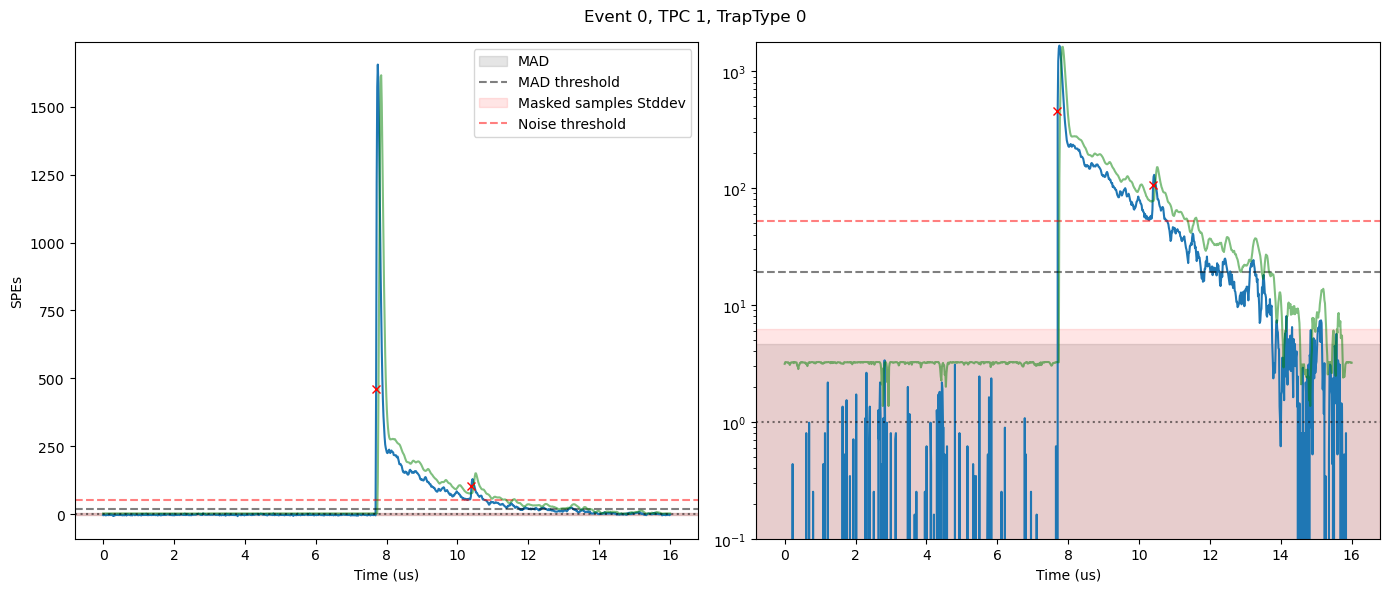

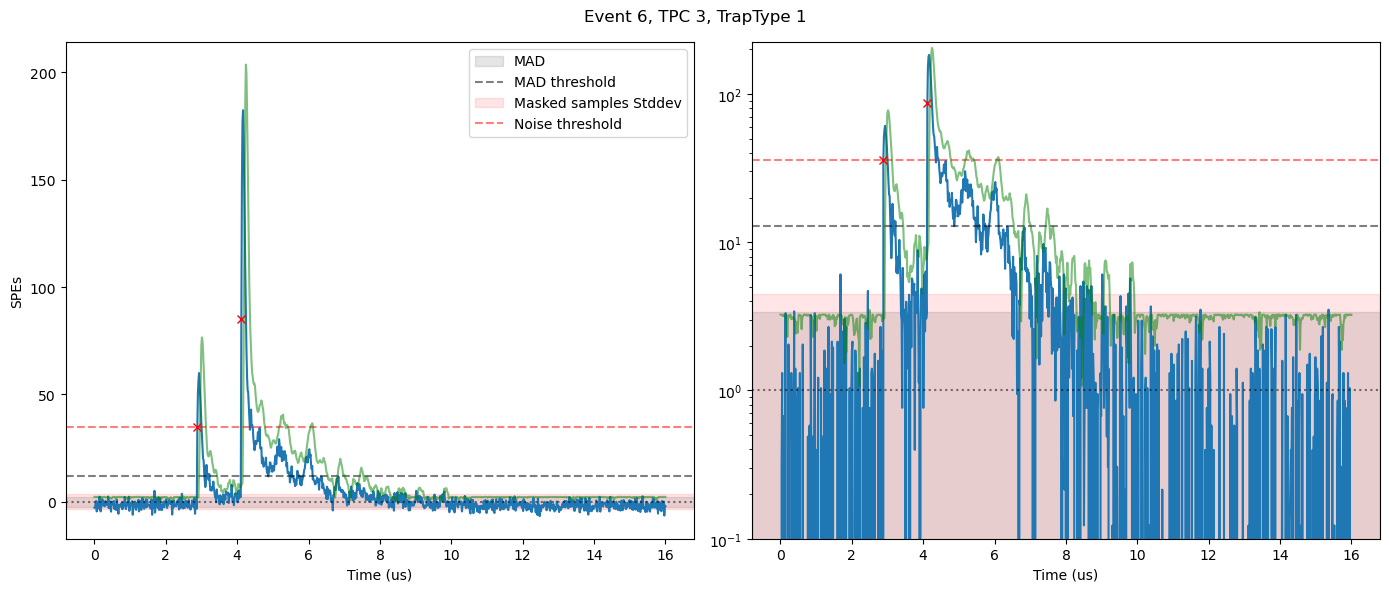

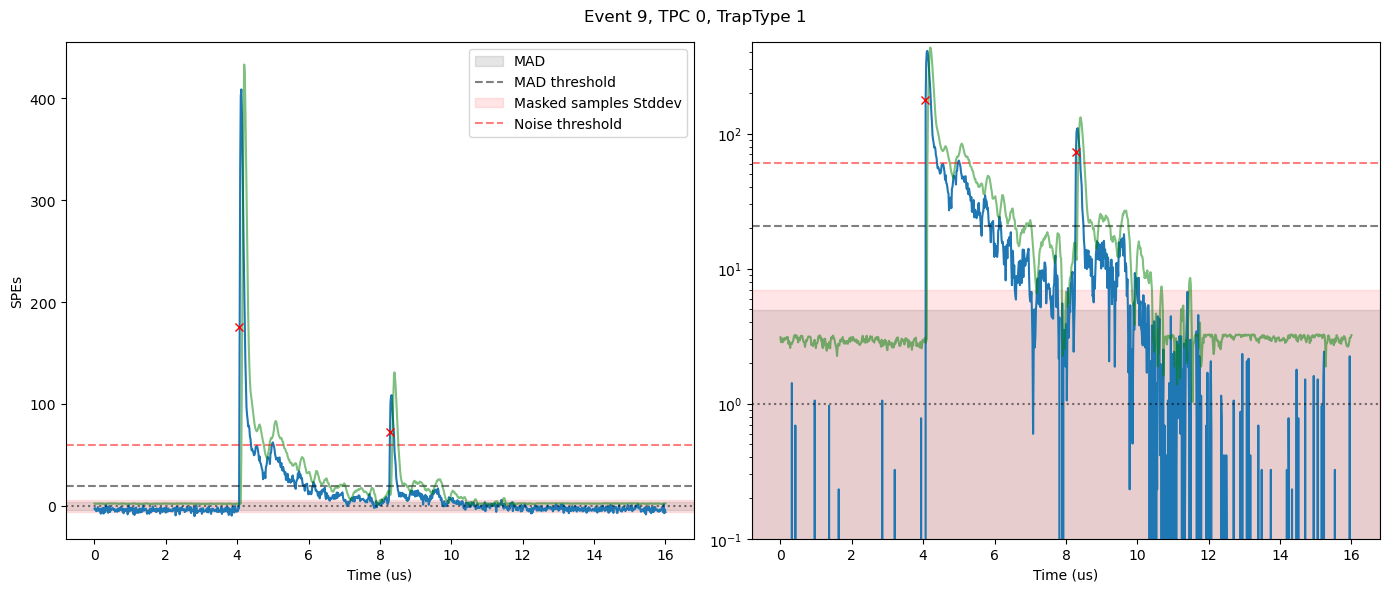

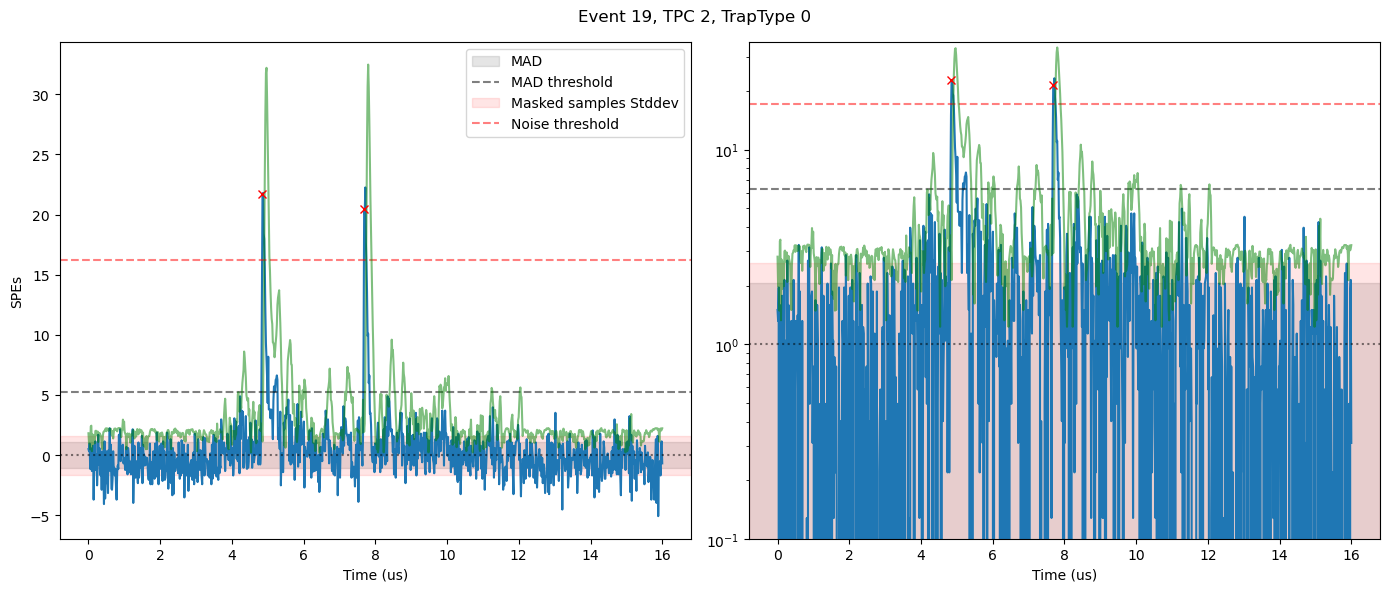

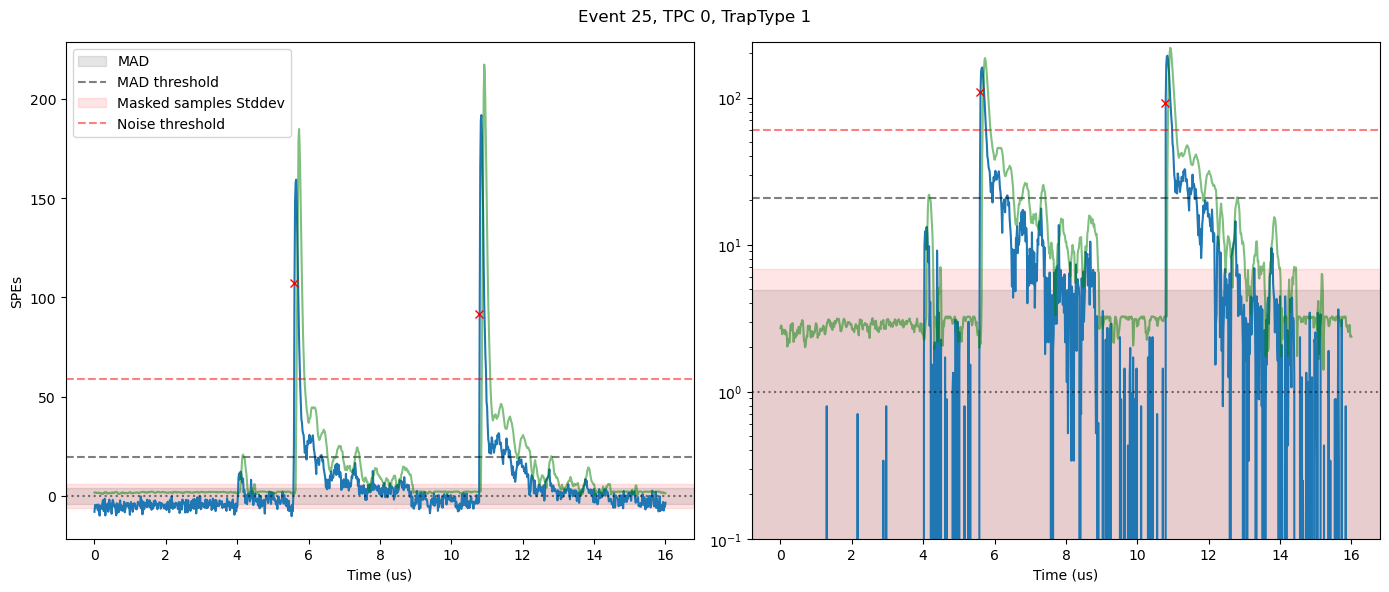

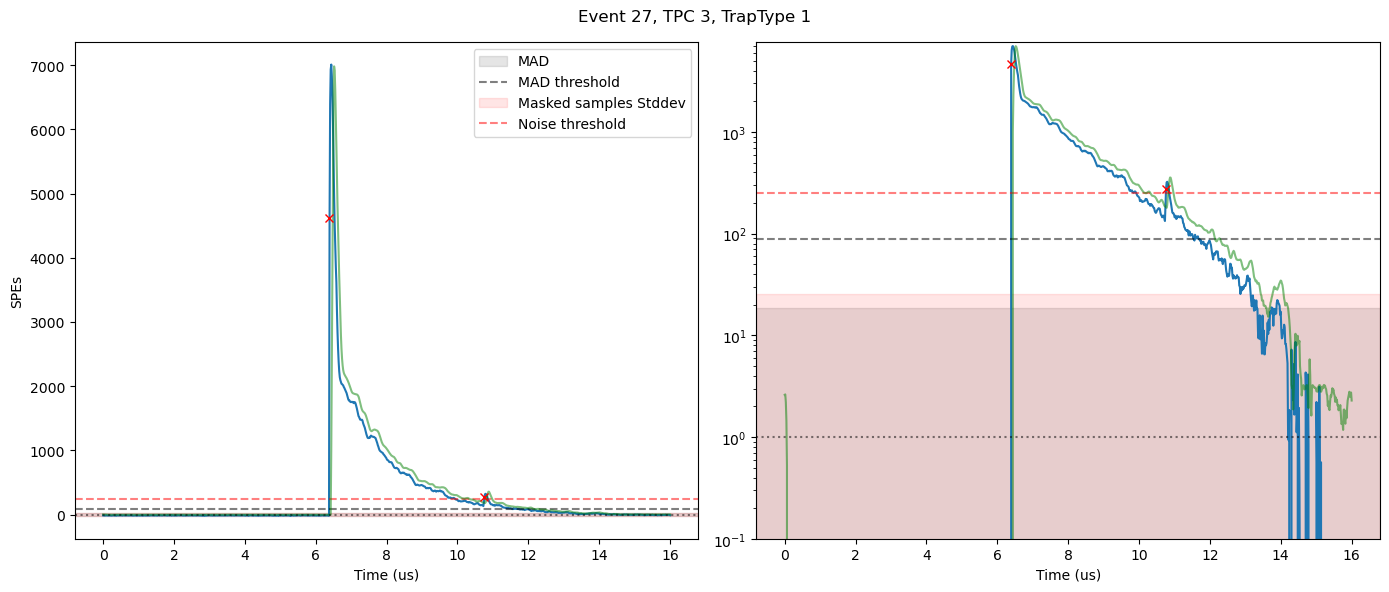

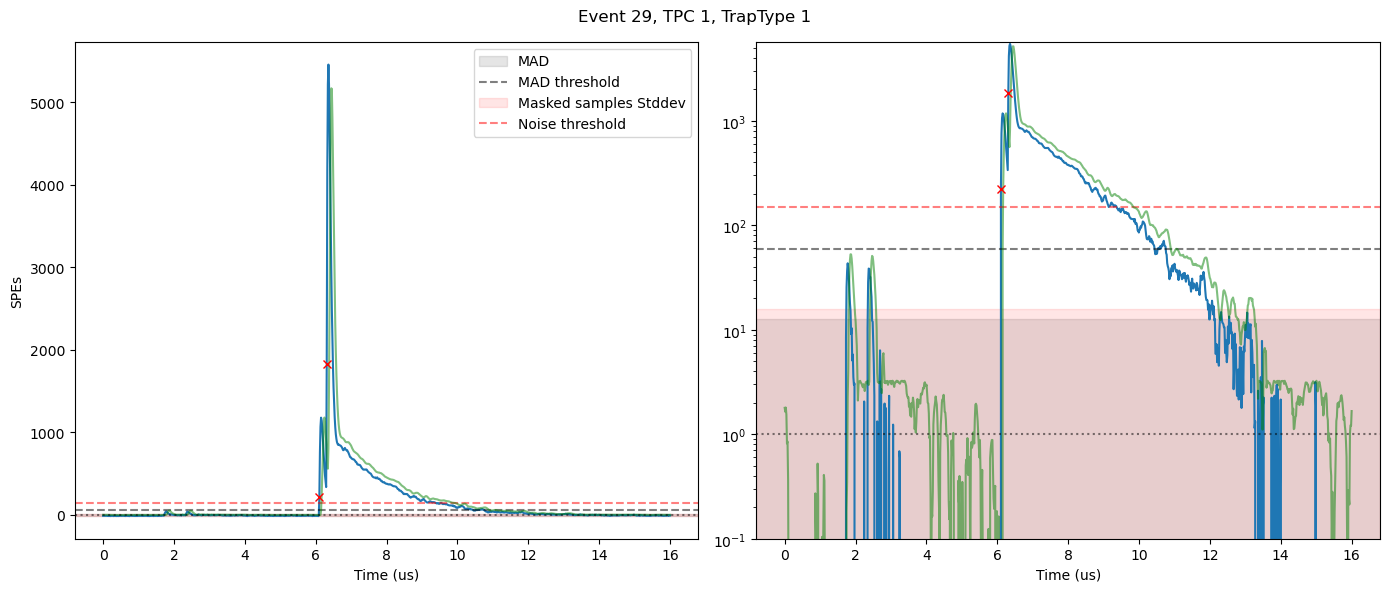

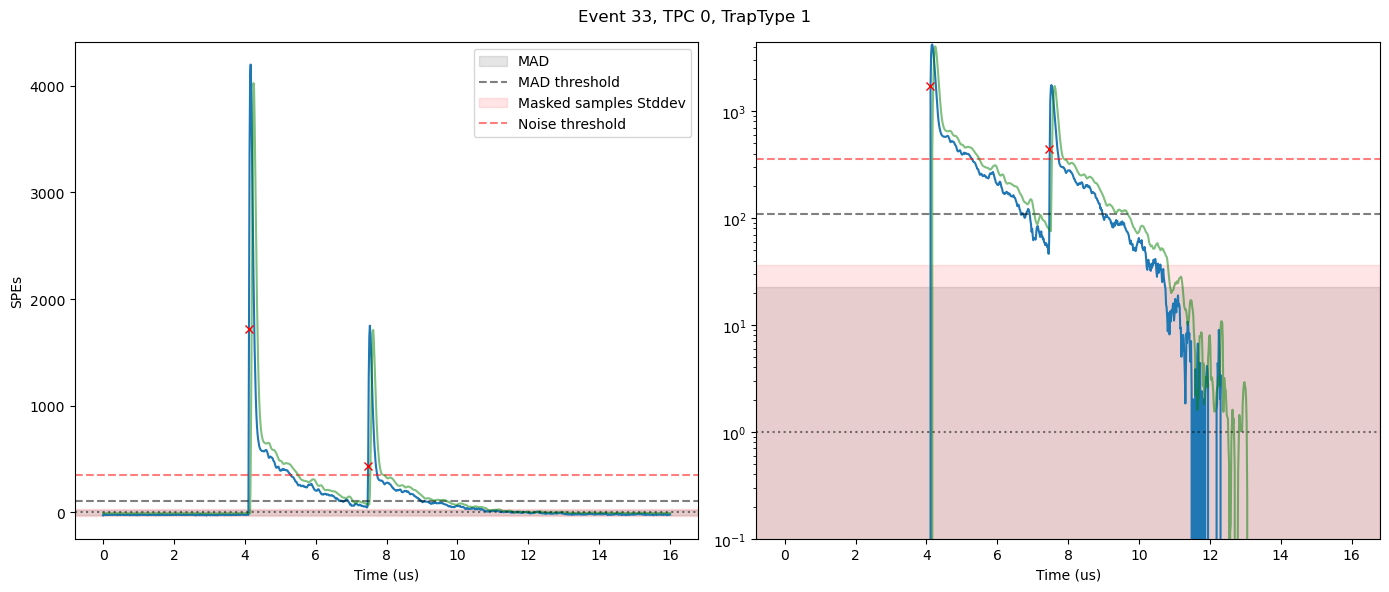

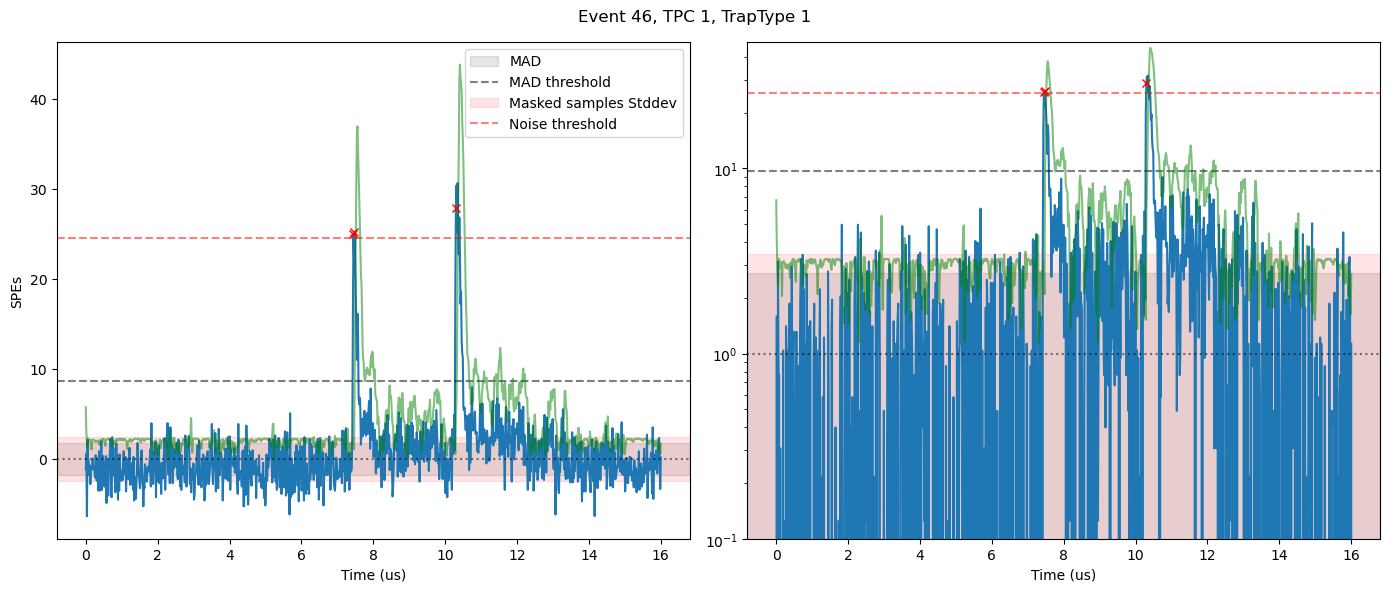

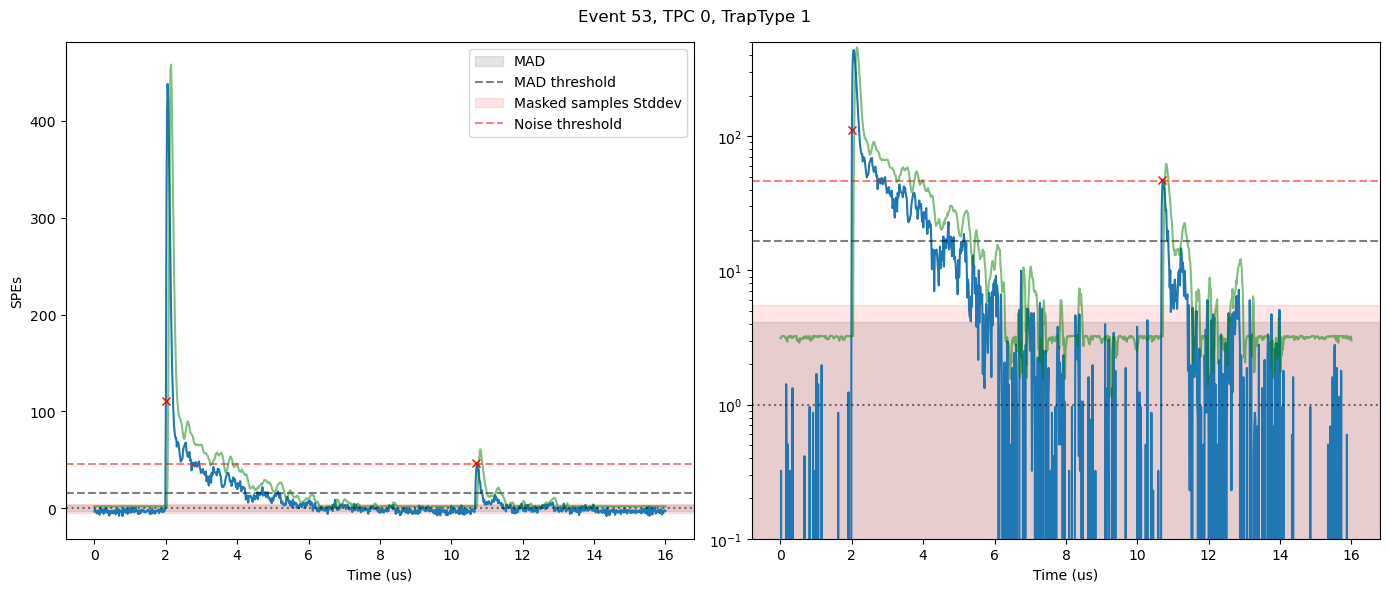

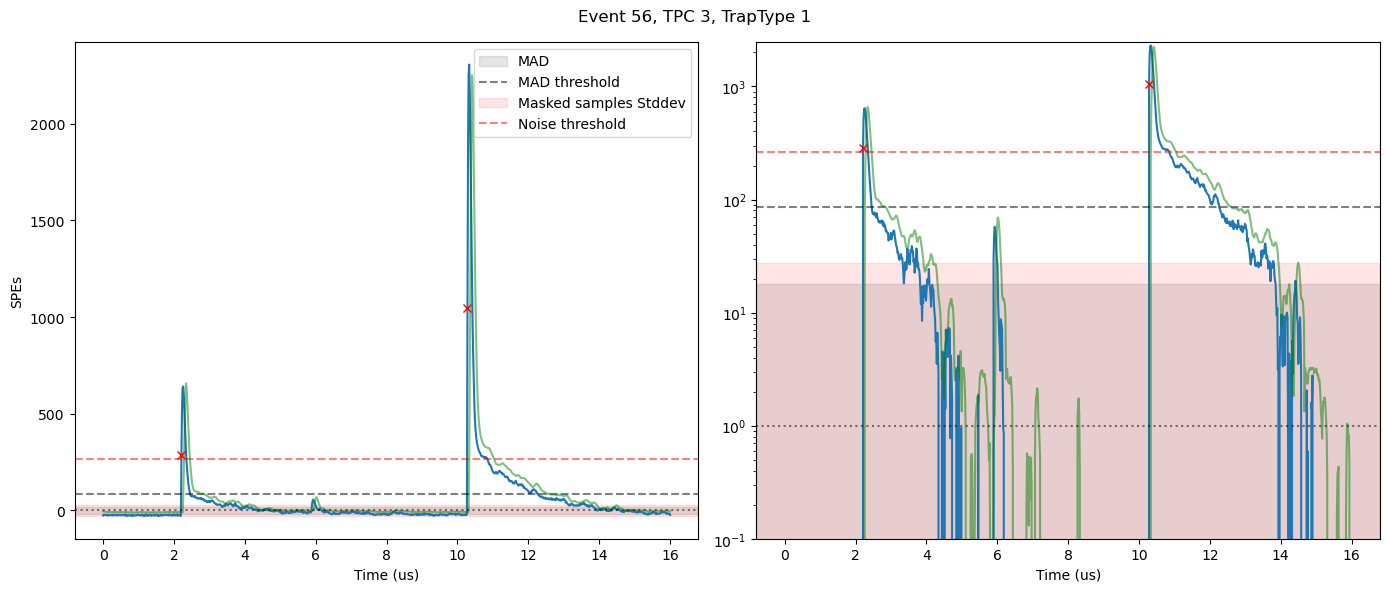

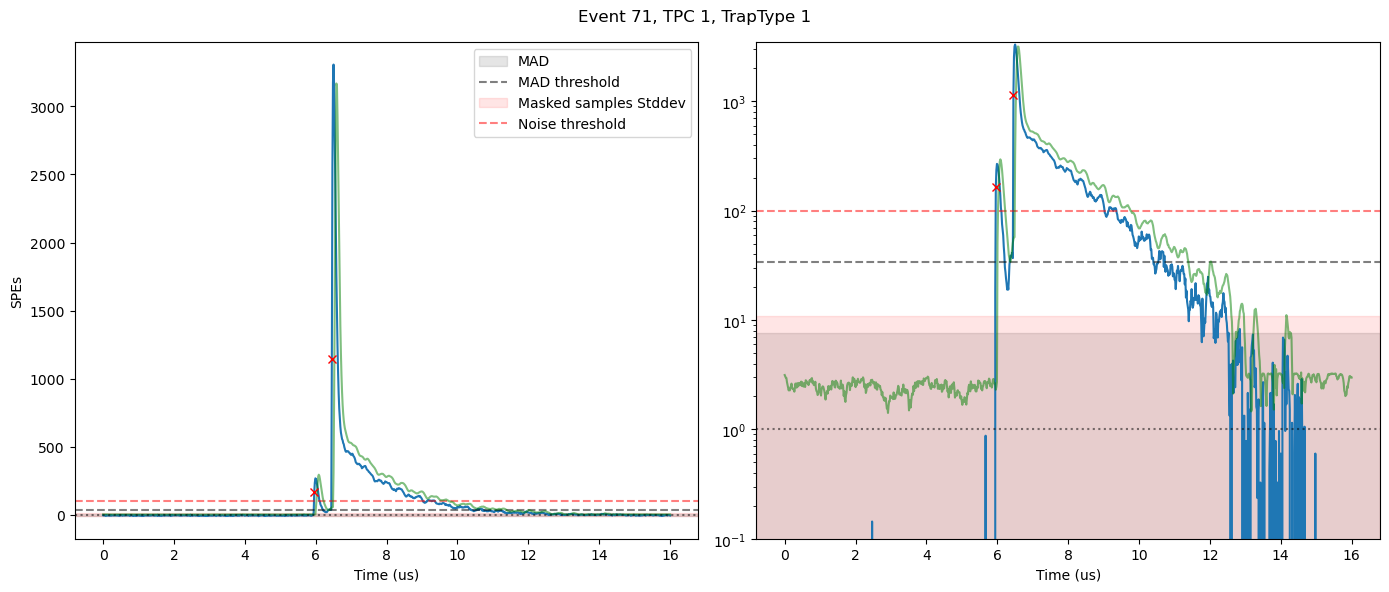

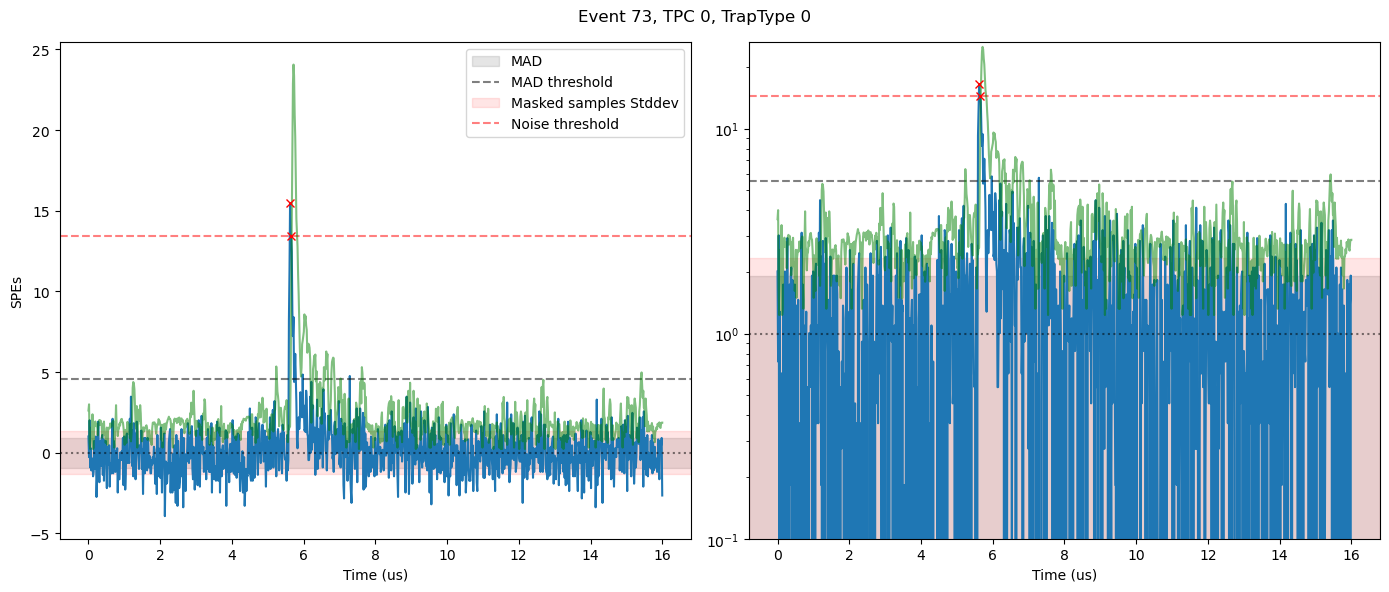

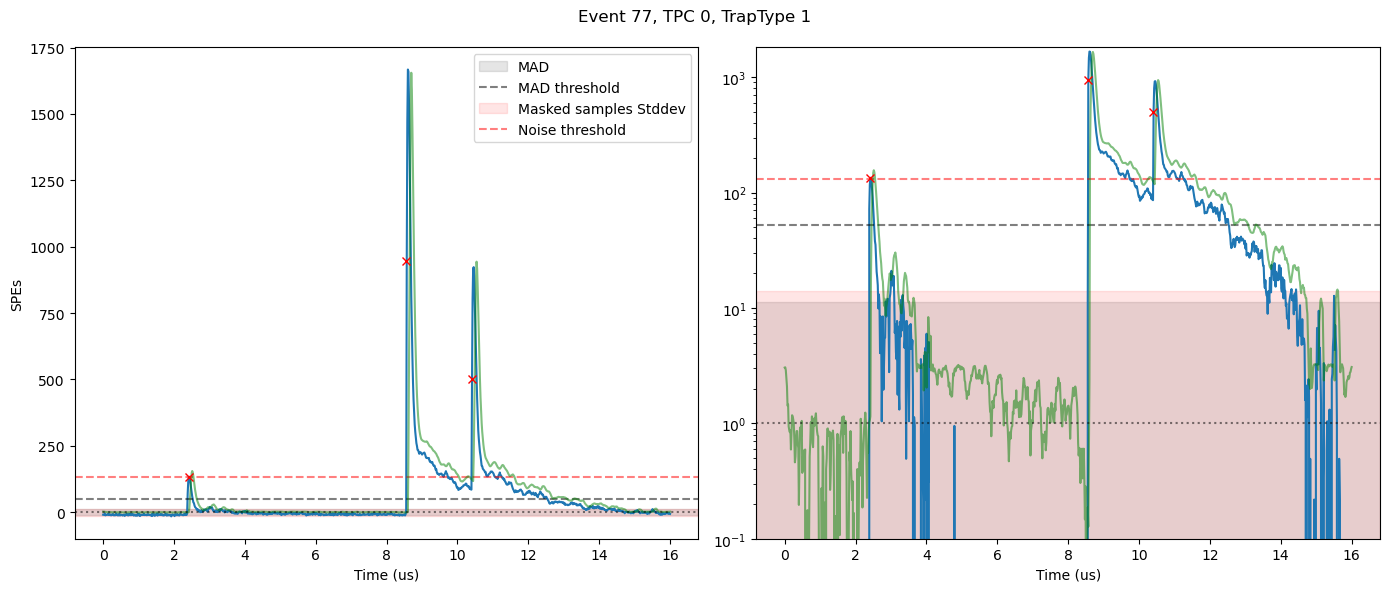

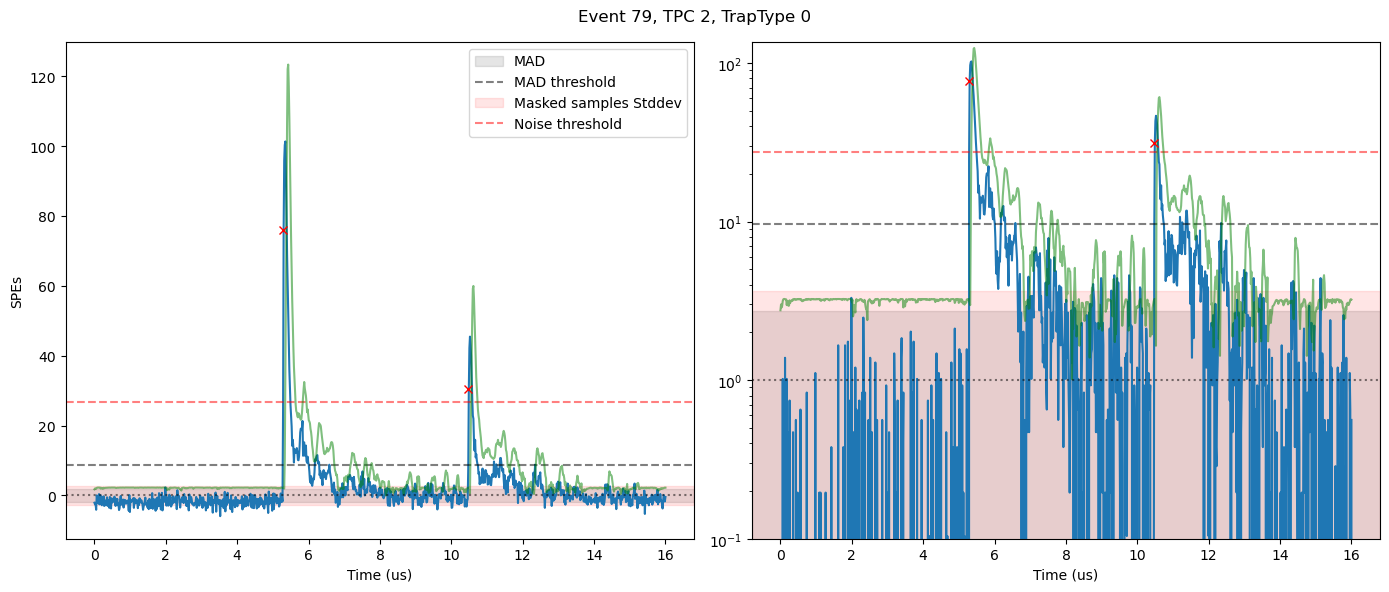

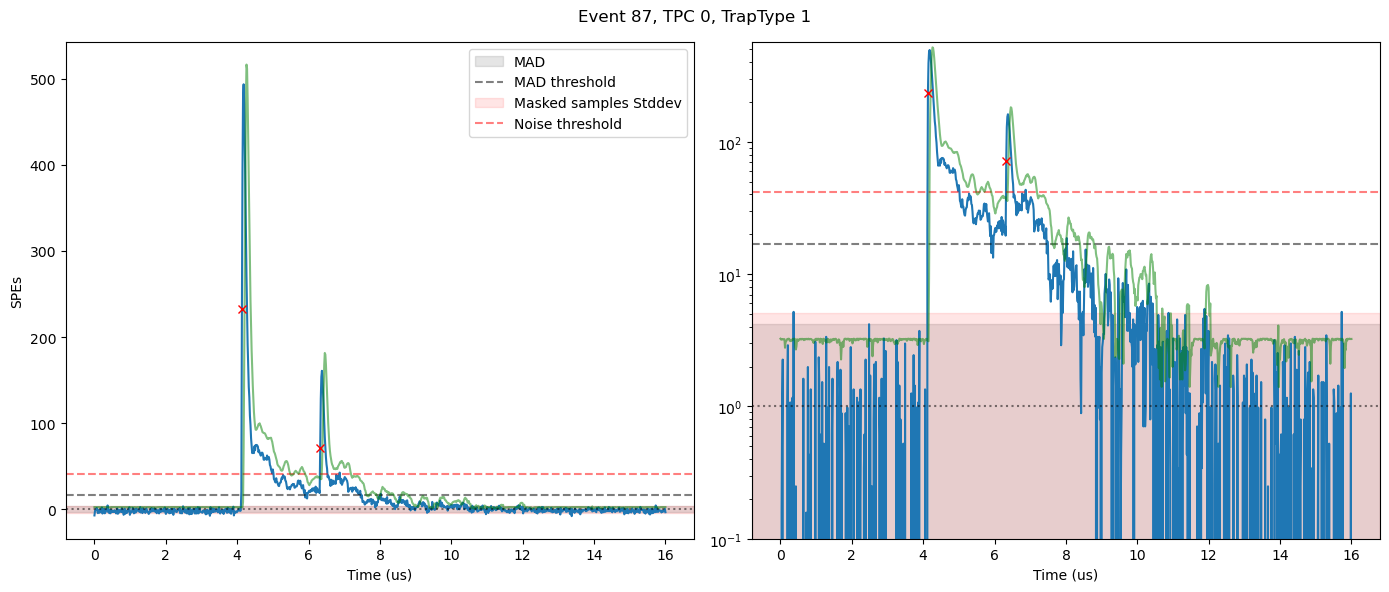

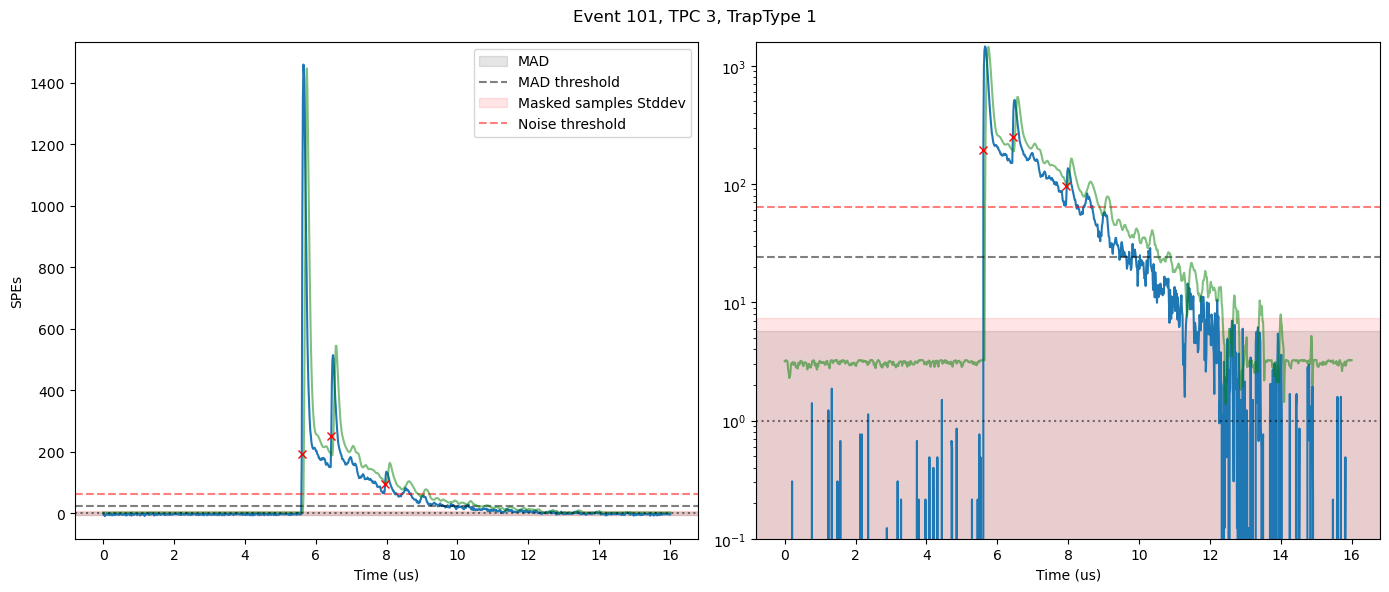

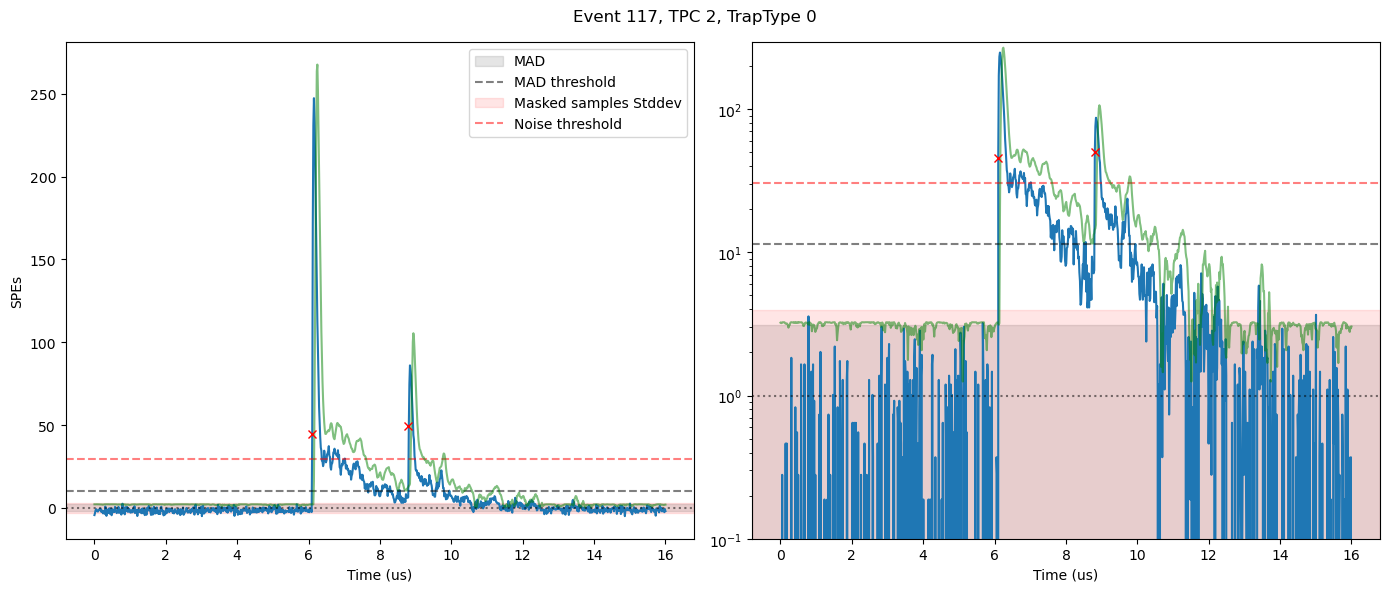

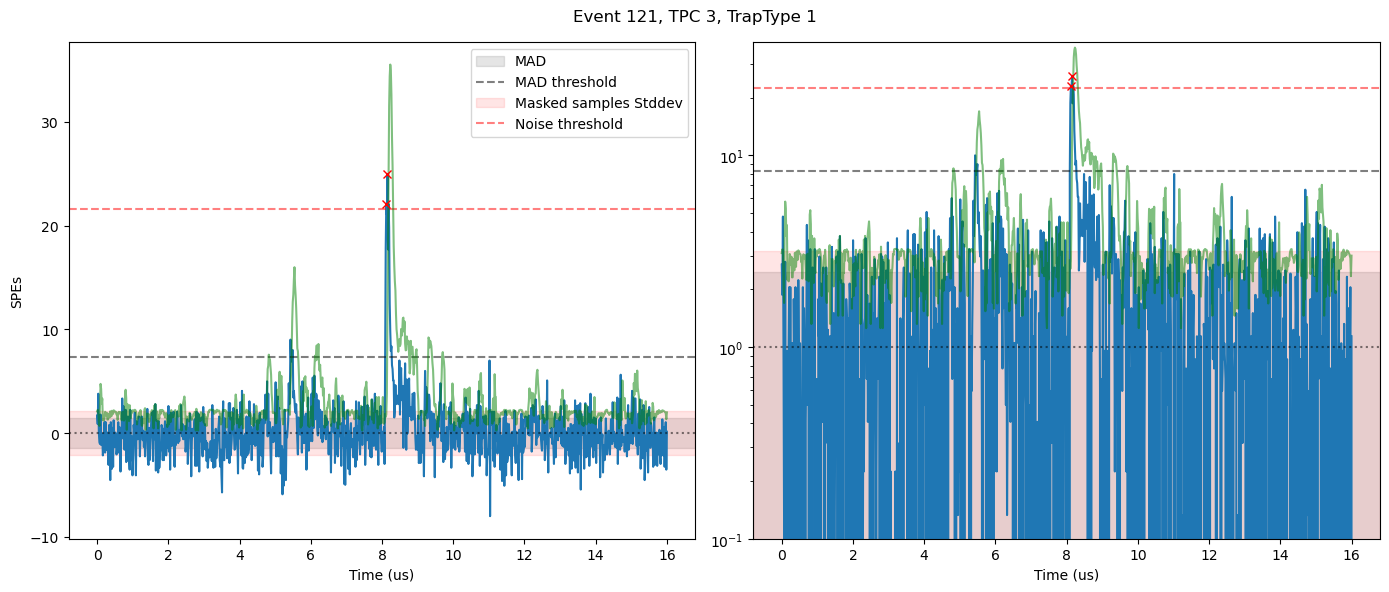

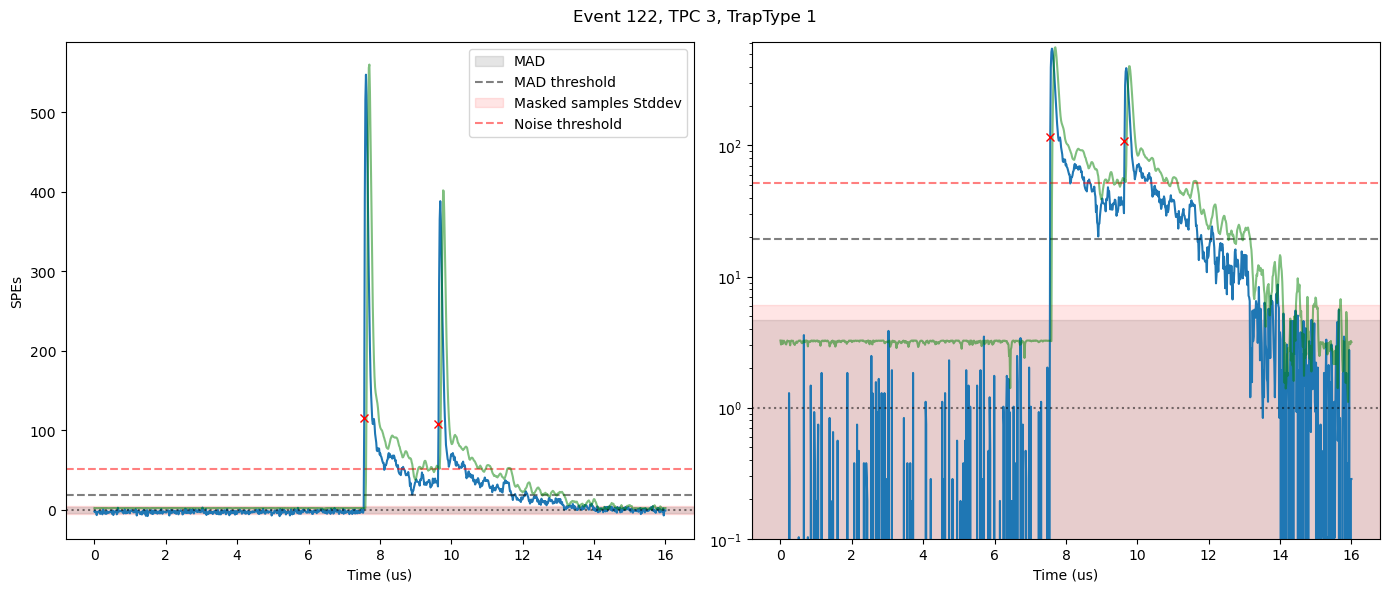

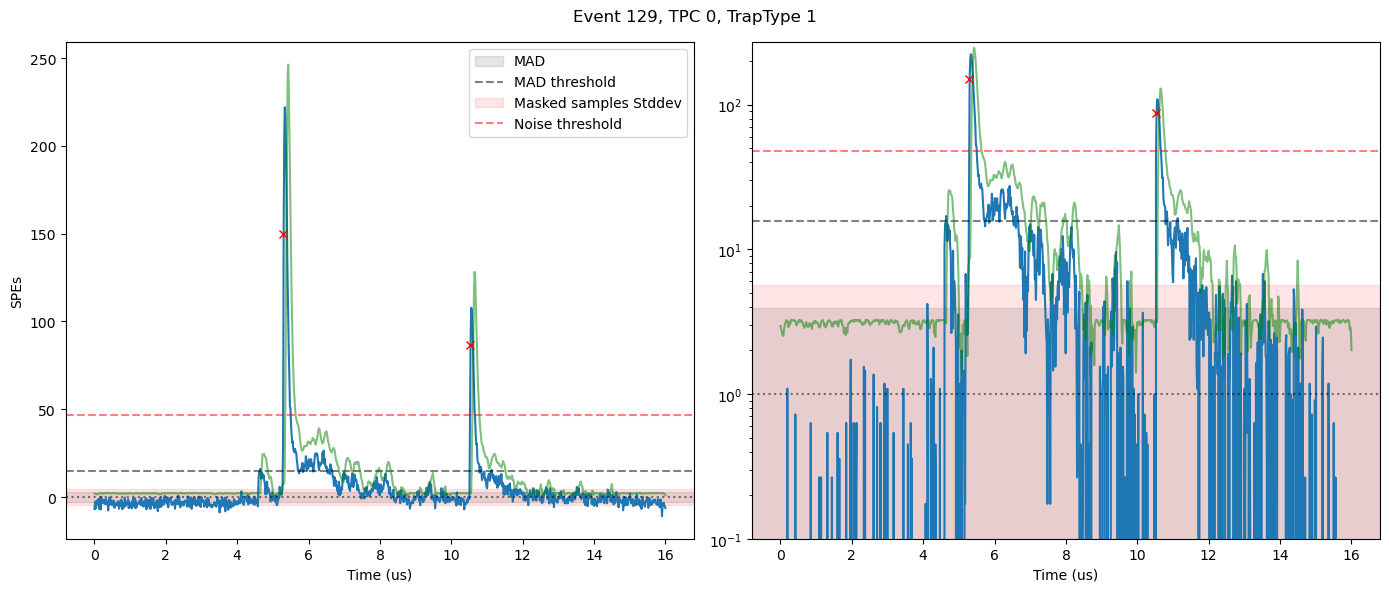

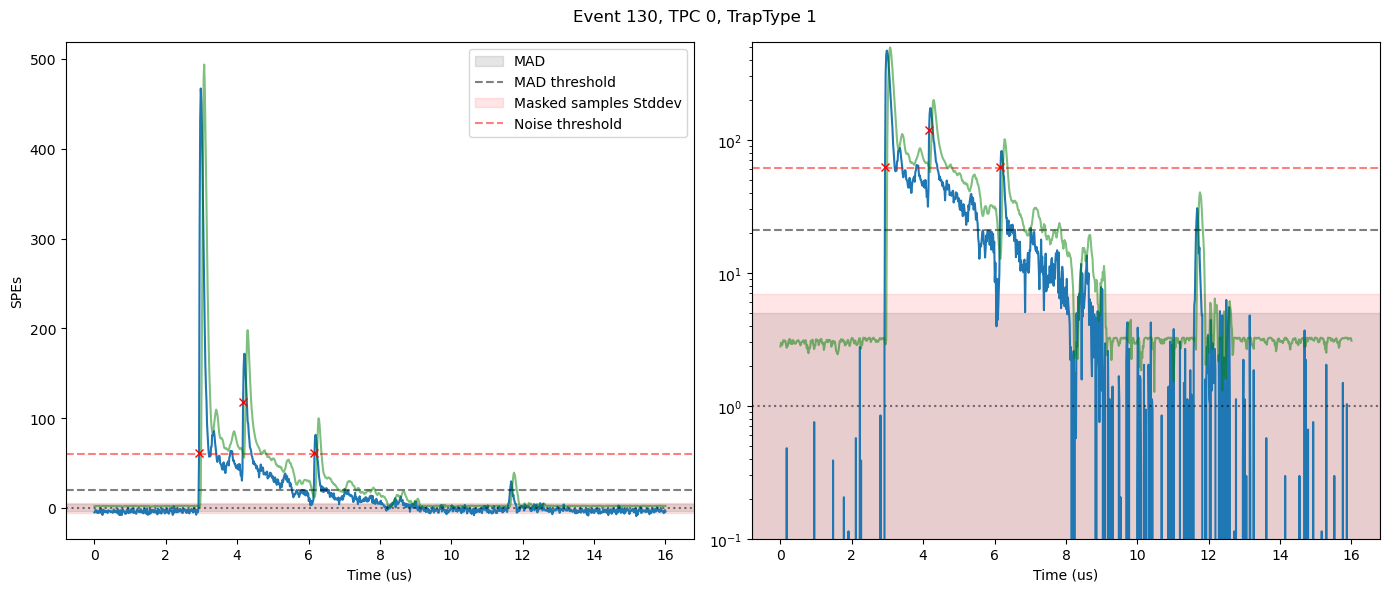

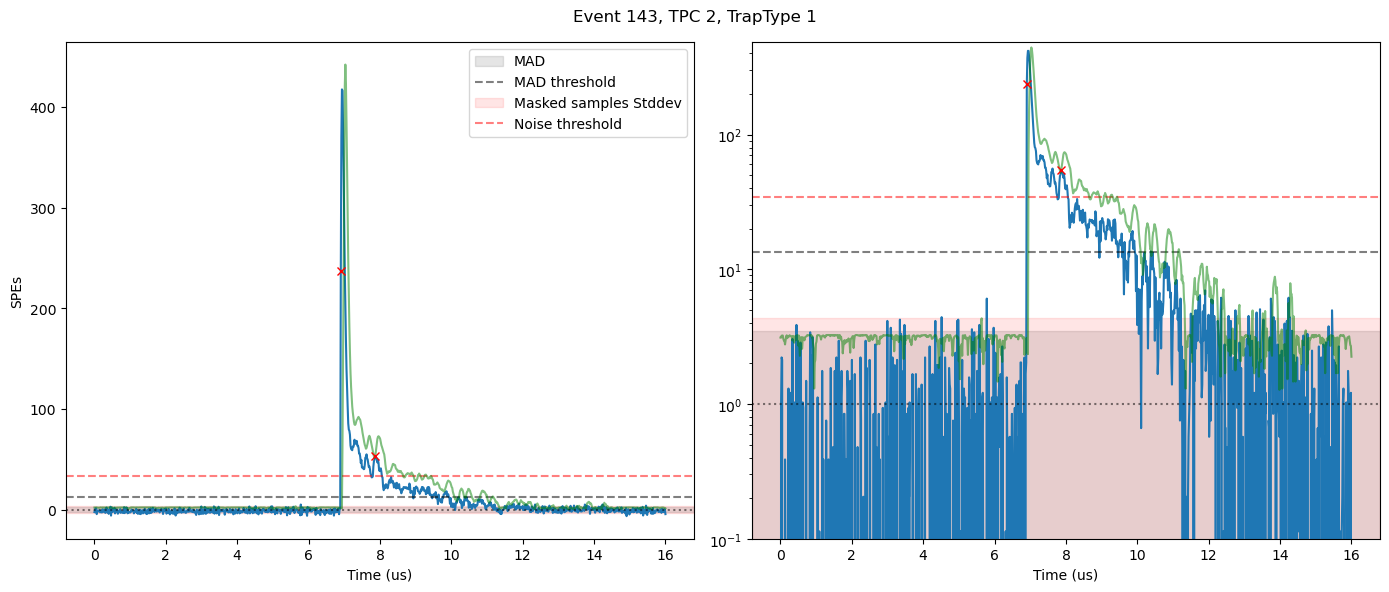

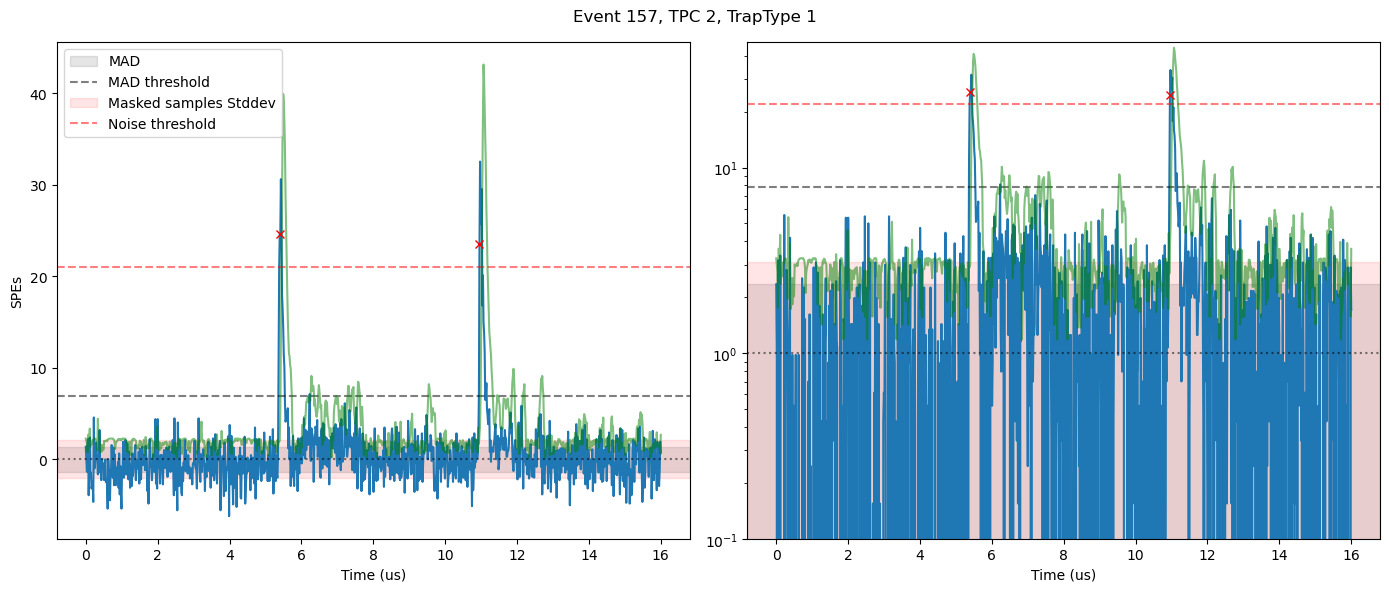

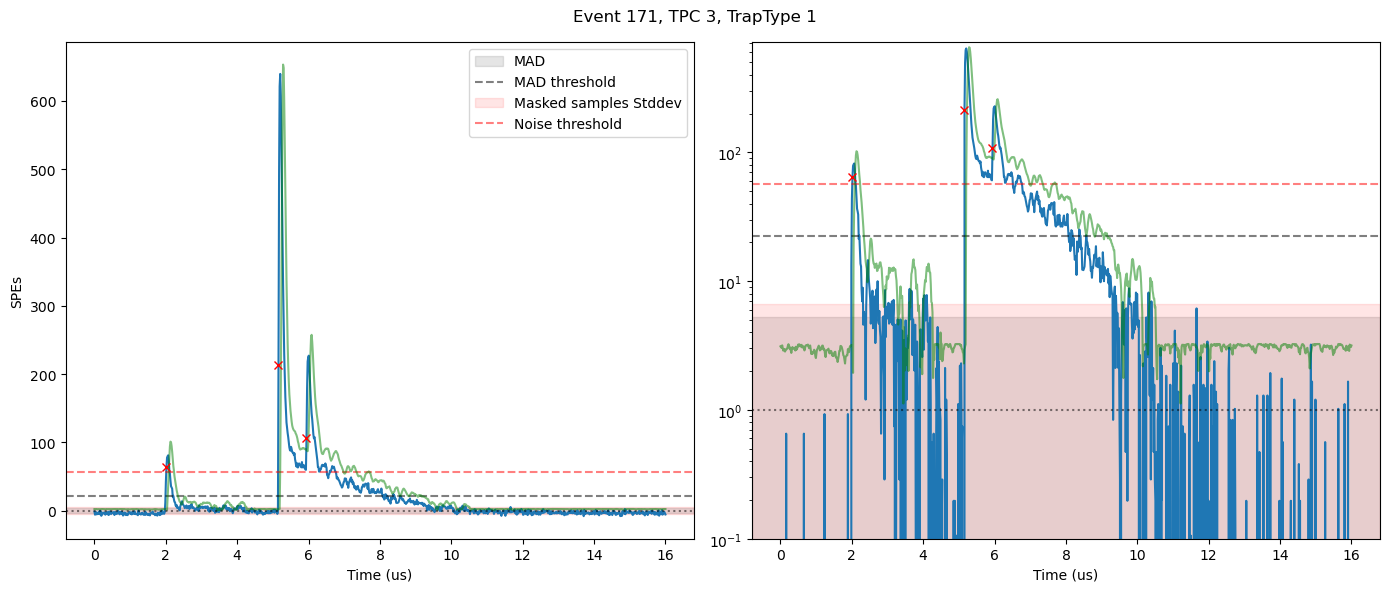

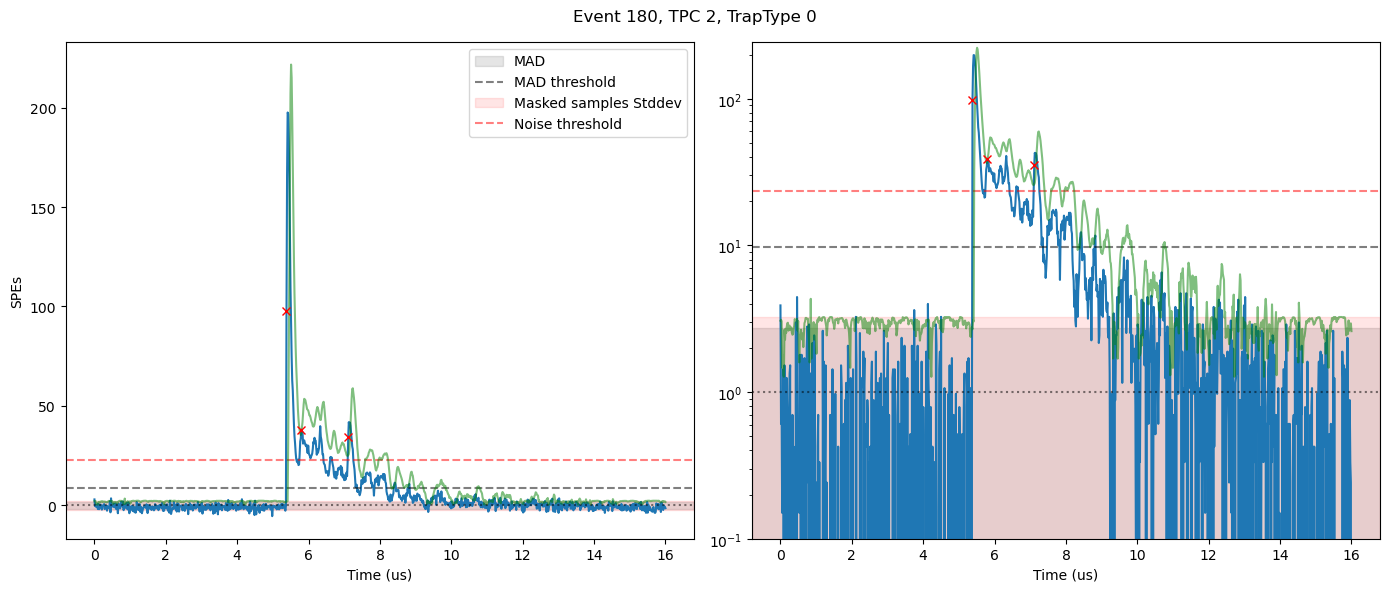

In [217]:
# plot the waveform of the trap with the highest wvfm in the event
for i_evt in range(0, summed_wvfms.shape[0]):

  # skip events with no hits
  all_traps = summed_wvfms[i_evt_lrs]
  all_heights = heights[i_evt_lrs]
  all_hits = hits[i_evt_lrs]

  # mask with the most hits
  i_mask = np.argmax(all_hits.sum(axis=1))
  i_evt_lrs = i_evt

  # get wvfm, threshold, and hits for the event
  wvfm = summed_wvfms[i_evt_lrs,i_mask]
  median = np.median(wvfm)
  mad = np.median(np.abs(wvfm - median))
  mad_threshold = 5*mad
  wvfm_rolled = np.roll(wvfm, n_bins_rolled)
  rolling_average = uniform_filter1d(wvfm_rolled, size=n_bins_rolled)
  sqrt_rolling_average = np.sqrt(np.abs(rolling_average) * pe_weight**2)
  dynamic_threshold = rolling_average + n_sqrt_rt_factor*sqrt_rolling_average
  height = heights[i_evt_lrs,i_mask]

  hit = hits[i_evt_lrs,i_mask]
  hit_where = np.where(hit)[0]
  if len(hit_where) < 2:
    continue

  plot_waveform(wvfm, time_bins, height, mad, 5.0, dynamic_threshold, hit_where, n_noise_factor, i_evt_lrs, i_mask)